###  **Question 1: IAQF Academic Competition**


*Imports*

In [2]:
import pandas as pd 
import numpy as np
import yfinance as yf
from datetime import date
import plotly.graph_objects as go

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression

##### **a) How much of the beta is driven by the seven versus the 493 other stocks (i.e. they probably have different betas – think three)?**

**Data**

*Read*

In [3]:
# Tickers
MAG7_TICKERS = ['AAPL','MSFT','TSLA','NVDA','META','AMZN','GOOG']
INDEX_TICKER = ['SPY']

# Start/End Dates
start_date, end_date = date(2010,1,1), date(2025,1,1)

# YFinance 
prices = yf.download(tickers = MAG7_TICKERS + INDEX_TICKER, start = start_date, end = end_date,auto_adjust = True)['Close']

# Market Cap Data
market_cap_dataframes = {ticker: pd.read_csv(f"../../data/{ticker}.O.csv", index_col=0) for ticker in MAG7_TICKERS}
market_cap_dataframes['SPY'] = pd.read_csv('../../data/SPX.GI.csv',index_col=0)
market_cap_data = pd.concat(market_cap_dataframes,names = ['Ticker'])


index_tickers = ['SPX.GI','S5COND.SPI','SPN.SPI', 'S5HLTH.SPI', 'S5INFT.SPI', 'S5TELS.SPI', 'S5CONS.SPI', 'SPF.SPI', 'S5INDU.SPI',
 'S5MATR.SPI','S5UTIL.SPI','S5RLST.SPI'] 

index_ticker_industry = {'SPX.GI': 'SPY',
         'S5COND.SPI': 'Consumer Discretioanry',
         'SPN.SPI': 'Energy',
         'S5HLTH.SPI': 'Health Care',
         'S5INFT.SPI': 'Technology',
         'S5TELS.SPI': 'Communication Service',
         'S5CONS.SPI': 'Consumer Staples',
         'SPF.SPI': 'Finance',
         'S5INDU.SPI': 'Industrials',
         'S5MATR.SPI': 'Materials',
         'S5UTIL.SPI': 'Utilities',
         'S5RLST.SPI': 'Real Estates',
         }

index_dataframes = {ticker: pd.read_csv(f'../../bill/Industry Index Data/{ticker}.csv',index_col=0) for  ticker in index_tickers}
index_market_cap_data = pd.concat(index_dataframes,names = ['Ticker'])

[*********************100%***********************]  8 of 8 completed


*Cleaning*

In [4]:
# YFinance Data
prices.index = pd.to_datetime(prices.index).date
returns = prices.pct_change().dropna()

# Market Cap Data
market_cap_data = (market_cap_data
      .reset_index()
      .rename(columns = {"level_1":'date','MKT_CAP_ARD':'market_cap'})
      .pivot(index = 'date',columns='Ticker',values = 'market_cap')
)

market_cap_data.index = pd.to_datetime(market_cap_data.index).date

mag7_weights_ts = (market_cap_data[MAG7_TICKERS]
                   .div(market_cap_data['SPY'],axis = 0)
                   .dropna()
)


# Index Market Cap Data
index_market_cap_data = (index_market_cap_data
      .reset_index()
      .rename(columns = {"level_1":'date','MKT_CAP_ARD':'market_cap'})
      .pivot(index = 'date',columns='Ticker',values = 'market_cap')
)
index_market_cap_data.index = pd.to_datetime(index_market_cap_data.index).date
industry_weights_ts = index_market_cap_data.div(index_market_cap_data.sum(axis = 1),axis = 0).dropna()

# Filter for Common Index
index_intersection = mag7_weights_ts.index.intersection(returns.index)

# Filter Weights + Returns
mag7_weights_ts = mag7_weights_ts.loc[index_intersection]
returns = returns.loc[index_intersection]

**Analysis**

*i)* Market Beta Contribution

In [5]:
# Beta Calculations
window = 252
mag7_beta_ts = {ticker: (returns[ticker].rolling(window).cov(returns['SPY']) / returns['SPY'].rolling(window).var()) for ticker in MAG7_TICKERS}
mag7_beta_ts = pd.DataFrame(mag7_beta_ts)

# Weighted Beta
weighted_beta_ts = (mag7_beta_ts*mag7_weights_ts).sum(axis = 1)

**Plots**

*i)* Mag 7 Weights

In [6]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = mag7_weights_ts.sum(axis = 1).index,
        y = mag7_weights_ts.sum(axis = 1)*100,
        name = 'Mag 7 Weight',
        mode='lines',
    )
)

fig.update_layout(title = 'Magnificent 7 Index Weight',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3) 
                )
fig.update_yaxes(title = "Weight (%)")
fig.show()

*ii)* Weighted Index Beta Contribution

In [7]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x = weighted_beta_ts[window:].index,
        y = weighted_beta_ts[window:],
        name = 'Magnificent Seven',
        mode='lines',
        line=dict(width=0.5, color='rgb(131, 90, 241)'),
        stackgroup='one',
        groupnorm='percent'
    )
)

fig.add_trace(go.Scatter(
    x= weighted_beta_ts[window:].index,
    y = 1 - weighted_beta_ts[window:], 
    mode='lines',
    name = 'Rest of Index',
    line=dict(width=0.5, color='rgb(127, 166, 238)'),
    stackgroup='one'
))

fig.update_layout(title = 'Weighted Index Beta Contribution',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = "Contribution %")
fig.update_xaxes(title = 'Date')
fig.show()

*iii)* Mag 7 Individual Betas

In [8]:
fig = go.Figure()

for ticker in mag7_beta_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = mag7_beta_ts[window:][ticker].index,
            y = mag7_beta_ts[window:][ticker],
            name = ticker
        )
    )

fig.update_layout(title = f'Magnificent Seven Betas, Window = {window}',
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = f"Beta")
fig.update_xaxes(title = 'Date')
fig.show()

*iv)* Normalized Mag7 Weights

In [9]:
mag7_weights_normalized_ts = mag7_weights_ts.div(mag7_weights_ts.sum(axis = 1),axis = 0)

fig = go.Figure()

for ticker in mag7_weights_normalized_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = mag7_weights_normalized_ts.index,
            y = mag7_weights_normalized_ts[ticker],
            name = ticker,
            stackgroup='one',
            groupnorm='percent'
        )
    )

fig.update_layout(title = 'Normalized Magnificent Seven Weights',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = "Weight (%)")
fig.update_xaxes(title = 'Date')
fig.show()

*iv)* Industry Weights

In [10]:
fig = go.Figure()

for ticker in industry_weights_ts.columns:
    fig.add_trace(
        go.Scatter(
            x = industry_weights_ts.index,
            y = industry_weights_ts[ticker]*100,
            name = index_ticker_industry[ticker],
            stackgroup='one',
            groupnorm='percent'
        )
    )

fig.update_layout(title = 'Industry Weights',
                  showlegend=True,yaxis=dict(type='linear',range=[1, 100],ticksuffix='%'),
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5)
                )
fig.update_yaxes(title = "Weight (%)")
fig.update_xaxes(title = 'Date')
fig.show()

##### **b) How does this affect the use of beta for evaluating/forecasting returns and the use of beta for investment decisions?**

**Data**

*Read*

In [11]:
# Risk Free Rate
risk_free_rate = yf.download(tickers= '^IRX',start = date(2015,1,1),end = date(2025,1,1))['Close']

# Extra Portfolio
UTILITIES_TICKERS = ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP'] #, 'CMS', 'ED']
prices_utilities = yf.download(tickers=UTILITIES_TICKERS,start = start_date,end = end_date)['Close']

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  7 of 7 completed


*Cleaning*

In [12]:
# Risk Free Daily
risk_free_rate = (risk_free_rate / 100) / 252
risk_free_rate.index = pd.to_datetime(risk_free_rate.index).date

# Utilities
returns_utilites = prices_utilities.pct_change().dropna()
returns_utilites.index = pd.to_datetime(returns_utilites.index).date

**Analysis**

##### *i)* CAPM $R^2$

In [13]:
# Copy Data
returns_mag7_excess = returns[MAG7_TICKERS].copy()
returns_utilities_excess = returns_utilites[UTILITIES_TICKERS].copy()
returns_index_excess = returns[INDEX_TICKER].copy()

# Get Data Intersection
index_intersection = (returns_mag7_excess.index.intersection(returns_index_excess.index)).intersection(returns_utilities_excess.index)
returns_mag7_excess = returns_mag7_excess.loc[index_intersection]
returns_utilities_excess = returns_utilities_excess.loc[index_intersection]
returns_index_excess = returns_index_excess.loc[index_intersection]

# Calculate Excess Returns
for ticker in MAG7_TICKERS:
    returns_mag7_excess[ticker] = returns_mag7_excess[ticker] - risk_free_rate['^IRX']

for ticker in UTILITIES_TICKERS:
    returns_utilities_excess[ticker] = returns_utilities_excess[ticker] - risk_free_rate['^IRX']

for ticker in INDEX_TICKER:
    returns_index_excess[ticker] = returns_index_excess[ticker] - risk_free_rate['^IRX']

# Drop NA Values
returns_utilities_excess = returns_utilities_excess.dropna()
returns_mag7_excess = returns_mag7_excess.dropna()
returns_index_excess = returns_index_excess.dropna() 

In [14]:
def rolling_capm(asset_returns,index_returns,window_size):

    rolling_results = []
    for start_idx in range(len(index_returns) - window_size + 1):
        end_idx = start_idx + window_size
        window_data = asset_returns.iloc[start_idx:end_idx]
        date_range = window_data.index
        # Perform CAPM regressions for each asset in the window
        for ticker in asset_returns.columns:
            y = window_data[ticker].dropna()
            x = index_returns.loc[y.index].values.reshape(-1, 1)
            if len(window_data) < window_size:
                continue
            # Fit linear regression
            model = LinearRegression().fit(x, y)
            # y_pred = model.predict(x)
            beta = model.coef_[0]
            alpha = model.intercept_
            
            # Calculate R2 and MAE
            r2 = model.score(x, y)
            # mae = mean_absolute_error(y, y_pred)
            
            # Store results
            rolling_results.append({
                "Start_Date": date_range[0],
                "End_Date": date_range[-1],
                "Asset": ticker,
                'Window':window_size,
                "R2": r2,
                'Beta':beta,
                "Alpha":alpha
                # "MAE": mae,
            })
    return pd.DataFrame(rolling_results)

In [15]:
rolling_capm_mag7 = rolling_capm(returns_mag7_excess,returns_index_excess,120)
rolling_capm_mag7 = rolling_capm_mag7.pivot(index = 'End_Date',columns = 'Asset',values = 'R2')

rolling_capm_utilities = rolling_capm(returns_utilities_excess,returns_index_excess,120)
rolling_capm_utilities = rolling_capm_utilities.pivot(index = 'End_Date',columns = 'Asset',values = 'R2')

##### *ii)* Hedging Efficiency

In [16]:
def hedge_effeciency(asset_returns,benchmark_returns,risk_free_rate,lookback= 120):

    # Ensure index alignment
    ii = (asset_returns.index.intersection(benchmark_returns.index)
          .intersection(risk_free_rate.index)
        )
    
    asset_returns = asset_returns[asset_returns.index.isin(ii)]
    benchmark_returns = benchmark_returns[benchmark_returns.index.isin(ii)]
    risk_free_rate = risk_free_rate[risk_free_rate.index.isin(ii)]


    # 
    portfolio_returns = asset_returns.mean(axis = 1)
    portfolio_data = pd.DataFrame({"Portfolio":portfolio_returns,
                                  'Benchmark':benchmark_returns}
                              )
    hedge_ratios = pd.Series(index = portfolio_data.index,dtype=float)

    for i in range(lookback+1,len(portfolio_data),lookback):
        
      window_rates = risk_free_rate.iloc[i-lookback:i]
      window_returns = portfolio_returns.iloc[i-lookback:i] - window_rates
      window_benchmark_returns = benchmark_returns.iloc[i-lookback:i] - window_rates

      if window_returns.isna().any() or window_benchmark_returns.isna().any():
          continue
      X = add_constant(window_benchmark_returns)
      y = window_returns
      model = OLS(y, X).fit()
      beta = model.params[0]
          
      # Store hedge ratio
      hedge_ratios.iloc[i:i+lookback] = -beta

    hedge_ratios.ffill(inplace = True)
    portfolio_data['Hedged'] = portfolio_data['Portfolio'] + hedge_ratios * portfolio_data['Benchmark']
    
    # Compute cumulative returns
    portfolio_data['Cumulative_Portfolio'] = (1 + portfolio_data['Portfolio']).cumprod()
    portfolio_data['Cumulative_Hedged'] = (1 + portfolio_data['Hedged']).cumprod()

    # Compute Hedge Effectiveness
    portfolio_data['HE'] = 1 - (portfolio_data['Hedged'].rolling(lookback).var() / portfolio_data['Portfolio'].rolling(lookback).var())

    return portfolio_data
    

In [17]:
mag7_HE = hedge_effeciency(returns[MAG7_TICKERS],returns['SPY'],risk_free_rate['^IRX'],200)
utilities_HE = hedge_effeciency(returns_utilites[UTILITIES_TICKERS],returns['SPY'],risk_free_rate['^IRX'],200)

#### *iii)* Forecasting

*Skipped*

#### **Plots**

##### **1) CAPM Regressions**

*i)* CAPM Regression $R^2$ MAG7

In [18]:
fig = go.Figure()

for ticker in rolling_capm_mag7.columns:

    fig.add_trace(
        go.Scatter(
            x = rolling_capm_mag7.index,
            y = rolling_capm_mag7[ticker],
            name = f'{ticker}'
        )
    )
fig.update_layout(title = 'CAPM Regression R2 (MAG7)')
fig.update_layout(
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3) 
                )
fig.update_yaxes(title = 'R2',range = [0,1])
fig.show()

*ii)* CAPM Regression $R^2$ MAG7

In [19]:
fig = go.Figure()

for ticker in rolling_capm_utilities.columns:

    fig.add_trace(
        go.Scatter(
            x = rolling_capm_utilities.index,
            y = rolling_capm_utilities[ticker],
            name = f'{ticker}'
        )
    )
fig.update_layout(title = 'CAPM Regression R2 (Utilities)')
fig.update_layout(
                  showlegend=True,
                  margin=dict(l=10, r=10, t=50, b=10),
                  legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5),
                  width = 800,height = 550,
                  xaxis_title = 'Date',
                  xaxis=dict(title_standoff=3) 
                )
fig.update_yaxes(title = 'R2',range = [0,1])
fig.show()

##### **2) Hedge Effeciency**

*i)* Magnificent Seven Hedging Effeciency

In [20]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = mag7_HE.index,
        y = mag7_HE['HE'],
        name = 'Hedge Effectiveness'
    )
)

fig.update_layout(title = 'Hedge Effectiveness (Magnificent Seven)')
fig.update_yaxes(title = 'Hedge Effectivenss',range = [0,1])
fig.update_xaxes(title = 'Date')
fig.show()

*ii)* Utilities Hedging Effeciency

In [21]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = utilities_HE.index.dropna(),
        y = utilities_HE['HE'].dropna(),
        name = 'Hedge Effectiveness'
    )
)

fig.update_layout(title = 'Hedge Effectiveness (Utilities)')
fig.update_yaxes(title = 'Hedge Effectivenss')
fig.update_xaxes(title = 'Date')
fig.show()

##### **c) What happens if there is a significant change in the price of one or more of those securities (especially since there may be significant interdependence due to the growth of AI investment by many of those firms)?**

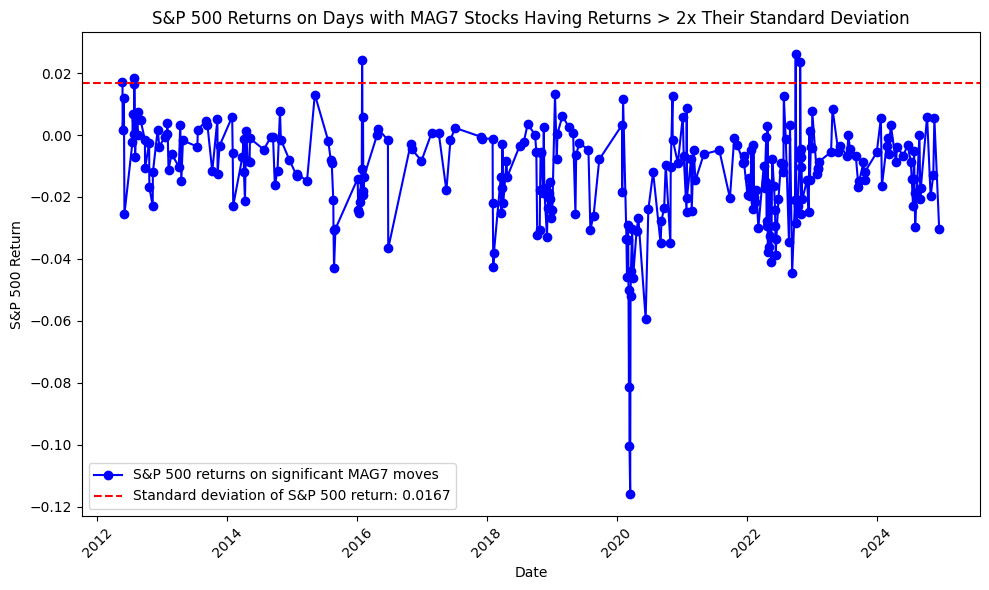

Standard deviation of S&P 500 return when any MAG7 stock has a move greater than 2x its standard deviation: 0.0167


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'returns' is your DataFrame with returns for MAG7 stocks and the S&P 500
# Example columns: 'tesla_return', 'apple_return', 'microsoft_return', ..., 'sp500_return'

# Define the number of standard deviations for the threshold
std_multiplier = 2  # You can adjust this multiplier to define the threshold

# Calculate the standard deviation for each MAG7 stock
std_devs = np.log(prices).diff().dropna()[MAG7_TICKERS].std()

# Create a mask for days when any of the MAG7 stocks have a return greater than 'std_multiplier' times their standard deviation
mask = (np.log(prices).diff().dropna()[MAG7_TICKERS] < -(std_multiplier * std_devs)).any(axis=1)

# Filter the dataframe for days with significant moves
significant_moves = np.log(prices).diff().dropna()[mask]

# Calculate the standard deviation of S&P 500 returns on these days
std_sp500_return = significant_moves['SPY'].std()

# Plot the S&P 500 returns for these days
plt.figure(figsize=(10,6))
plt.plot(significant_moves.index, significant_moves['SPY'], marker='o', linestyle='-', color='b', label='S&P 500 returns on significant MAG7 moves')
plt.axhline(y=std_sp500_return, color='r', linestyle='--', label=f'Standard deviation of S&P 500 return: {std_sp500_return:.4f}')
plt.title(f'S&P 500 Returns on Days with MAG7 Stocks Having Returns > {std_multiplier}x Their Standard Deviation')
plt.xlabel('Date')
plt.ylabel('S&P 500 Return')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the standard deviation
print(f"Standard deviation of S&P 500 return when any MAG7 stock has a move greater than {std_multiplier}x its standard deviation: {std_sp500_return:.4f}")

In [34]:
significant_moves.head()

Ticker          AAPL      AMZN      GOOG      META      MSFT      NVDA  \
2012-05-21  0.056627  0.019725  0.022578 -0.116378  0.016266  0.017235   
2012-05-22 -0.007710 -0.012828 -0.021912 -0.093255  0.000336 -0.012280   
2012-05-29  0.017593  0.008699  0.004739 -0.101156  0.017059  0.025479   
2012-06-01 -0.029404 -0.022274 -0.017156 -0.065620 -0.025678 -0.036874   
2012-07-16  0.003202 -0.010958 -0.002779 -0.083820  0.001700  0.003179   

Ticker           SPY      TSLA  
2012-05-21  0.017043  0.042968  
2012-05-22  0.001741  0.068181  
2012-05-29  0.012039  0.061158  
2012-06-01 -0.025499 -0.046843  
2012-07-16 -0.002360  0.048721

In [50]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = significant_moves.index,
        y = significant_moves['SPY'],
        name = 'SPY Daily Log Return',
        mode = 'lines+markers'
    )
)

fig.add_hline(y = 0,line = dict(color = 'red'))
fig.update_layout(title = 'SPY Log Return given any MAG7 negative 2sigma move')
fig.update_yaxes(title = 'Daily Log Returns',range = [-0.15,0.1])
fig.show()

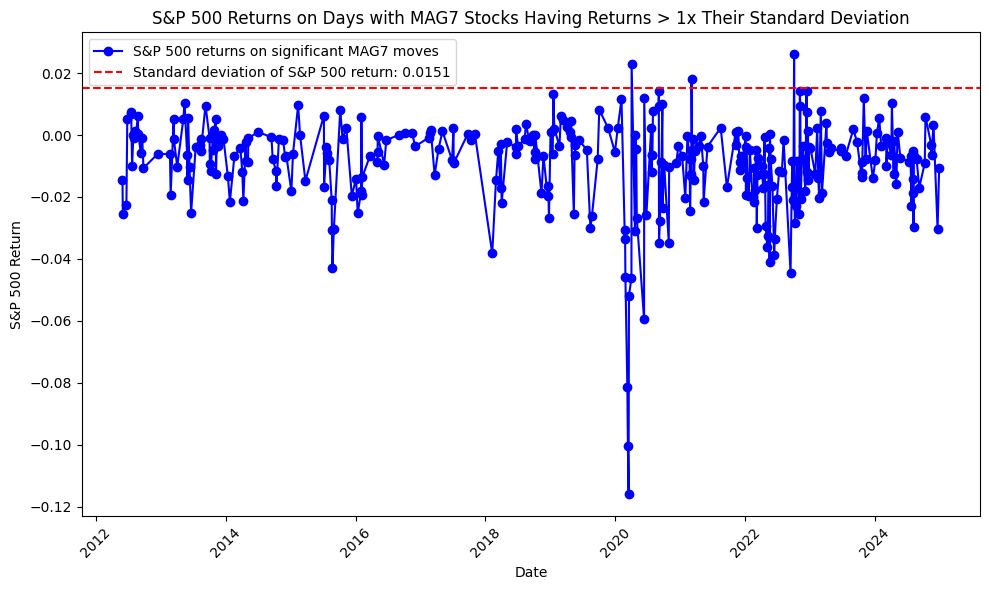

Standard deviation of S&P 500 return when any MAG7 stock has a move greater than 1x its standard deviation: 0.0151


In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'returns' is your DataFrame with returns for MAG7 stocks and the S&P 500
# Example columns: 'tesla_return', 'apple_return', 'microsoft_return', ..., 'sp500_return'

# Define the number of standard deviations for the threshold
std_multiplier = 1  # You can adjust this multiplier to define the threshold

# Calculate the standard deviation for each MAG7 stock
std_devs = np.log(prices).diff().dropna()['TSLA'].std()

# Create a mask for days when any of the MAG7 stocks have a return greater than 'std_multiplier' times their standard deviation
mask = (np.log(prices).diff().dropna()['TSLA'] < -(std_multiplier * std_devs))

# Filter the dataframe for days with significant moves
significant_moves = np.log(prices).diff().dropna()[mask]

# Calculate the standard deviation of S&P 500 returns on these days
std_sp500_return = significant_moves['SPY'].std()

# Plot the S&P 500 returns for these days
plt.figure(figsize=(10,6))
plt.plot(significant_moves.index, significant_moves['SPY'], marker='o', linestyle='-', color='b', label='S&P 500 returns on significant MAG7 moves')
plt.axhline(y=std_sp500_return, color='r', linestyle='--', label=f'Standard deviation of S&P 500 return: {std_sp500_return:.4f}')
plt.title(f'S&P 500 Returns on Days with MAG7 Stocks Having Returns > {std_multiplier}x Their Standard Deviation')
plt.xlabel('Date')
plt.ylabel('S&P 500 Return')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the standard deviation
print(f"Standard deviation of S&P 500 return when any MAG7 stock has a move greater than {std_multiplier}x its standard deviation: {std_sp500_return:.4f}")

In [51]:
significant_moves['SPY'].mean()*100

np.float64(-1.2353800563173951)

In [23]:
returnsshort=np.log(prices).diff().dropna().copy()
returnsshort
returnsshort.std()

returnssig=returnsshort.loc[(abs(returnsshort)>2*returnsshort.std()).sum(axis=1)>0]

# Create a dictionary to store betas

# List of stocks
stocks = ['AAPL', 'TSLA', 'GOOG', 'AMZN', 'MSFT', 'NVDA', 'META']

# Create a dictionary to store betas
betas = {}

# Loop through each stock and calculate beta
for stock in stocks:
    # Independent variable (individual stock returns)
    X = returnssig[stock].values.reshape(-1, 1)  # Reshape for sklearn
    
    # Dependent variable (S&P 500 returns, ^GSPC)
    y = returnssig['SPY'].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the beta (slope of the regression line)
    betas[stock] = model.coef_[0]

# Convert betas to a DataFrame for better visualization
betas_df = pd.DataFrame(list(betas.items()), columns=['Stock', 'Beta'])

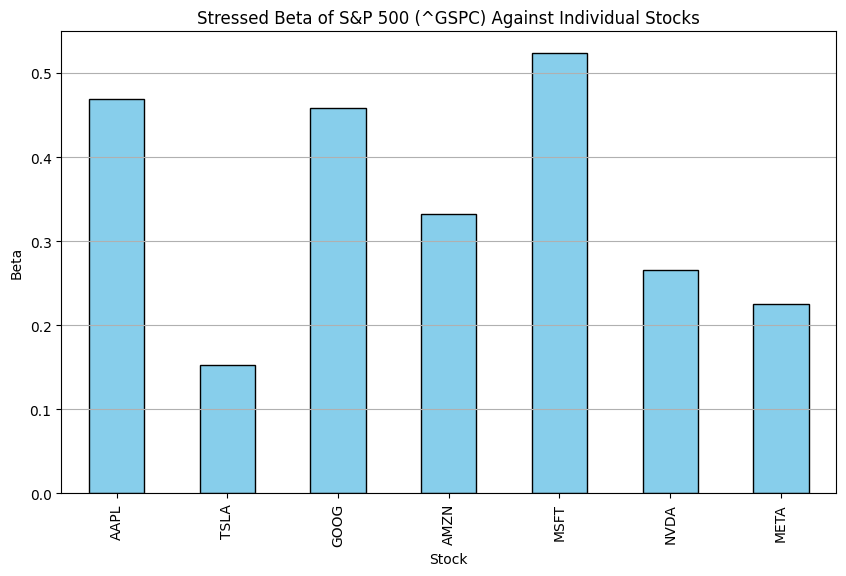

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
betas_df.set_index('Stock')['Beta'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Stressed Beta of S&P 500 (^GSPC) Against Individual Stocks')
plt.xlabel('Stock')
plt.ylabel('Beta')
plt.grid(axis='y')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1504.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        12:35:29   Log-Likelihood:                 9617.9
No. Observations:                2534   AIC:                        -1.922e+04
Df Residuals:                    2528   BIC:                        -1.919e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      4.973      0.0

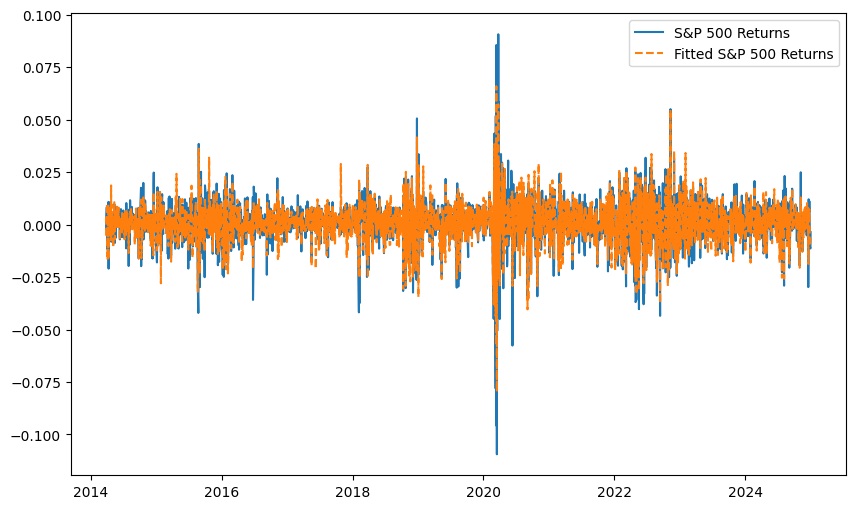

In [56]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume df is your DataFrame with MAG7 stock returns and SP500 returns
MAG7_returns = returns[MAG7_TICKERS]  # e.g., Apple, Tesla, etc.
SP500_returns = returns['SPY']

# Standardize the returns
MAG7_returns = (MAG7_returns - MAG7_returns.mean()) / MAG7_returns.std()

# Perform PCA
pca = PCA(n_components=5)  # Use the top 5 components, for example
principal_components = pca.fit_transform(MAG7_returns)

# Create a binary signal for significant moves (e.g., 5% move)
threshold = 0.05
significant_moves = (MAG7_returns.abs() > threshold).any(axis=1)

# For significant move days, analyze the correlation with S&P 500
significant_sp500_returns = SP500_returns[significant_moves]

# Regress SP500 returns on the first principal component (or all components)
import statsmodels.api as sm
X = sm.add_constant(principal_components[significant_moves, :])
y = significant_sp500_returns
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# Plot the S&P 500 returns and the principal components on significant move days
plt.figure(figsize=(10, 6))
plt.plot(significant_sp500_returns.index, significant_sp500_returns, label="S&P 500 Returns")
plt.plot(significant_sp500_returns.index, model.fittedvalues, label="Fitted S&P 500 Returns", linestyle='--')
plt.legend()
plt.show()

           PC1       PC2       PC3       PC4       PC5
AAPL  0.382410  0.044394 -0.423971 -0.292222  0.665067
MSFT  0.421549 -0.098535 -0.290665 -0.141996 -0.109397
TSLA  0.283616  0.892342  0.327270 -0.063995  0.018182
NVDA  0.376084  0.095358 -0.373877  0.790268 -0.209951
META  0.351436 -0.345000  0.664593  0.334514  0.430451
AMZN  0.396801 -0.139662  0.214728 -0.290655 -0.533216
GOOG  0.416201 -0.210765  0.032879 -0.263522 -0.178051


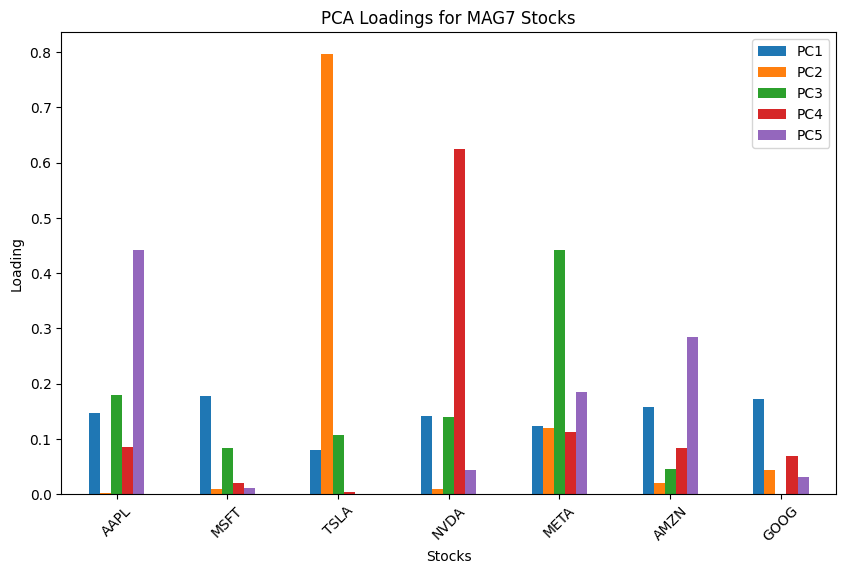

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Assume df is your DataFrame with MAG7 stock returns
MAG7_returns = np.log(prices).diff().dropna()[MAG7_TICKERS]  # e.g., Apple, Tesla, etc.

# Standardize the returns
MAG7_returns = (MAG7_returns - MAG7_returns.mean()) / MAG7_returns.std()

# Perform PCA
pca = PCA(n_components=5)  # Using top 5 components
pca.fit(MAG7_returns)

# Get the loadings (weights) of the principal components
loadings = pca.components_

# Create a DataFrame to show the loadings with the stock tickers as the index
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=MAG7_TICKERS)

# Display the loadings
print(loadings_df)

# Optionally, you can also visualize the loadings
import matplotlib.pyplot as plt
(loadings_df**2).plot(kind='bar', figsize=(10, 6))
plt.title('PCA Loadings for MAG7 Stocks')
plt.ylabel('Loading')
plt.xlabel('Stocks')
plt.xticks(rotation=45)
plt.show()

In [81]:
prices.iloc[-252:]

Ticker            AAPL        AMZN        GOOG        META        MSFT  \
2024-01-02  184.532074  149.929993  139.060349  344.972229  368.117249   
2024-01-03  183.150391  148.470001  139.857483  343.159149  367.849243   
2024-01-04  180.824341  144.570007  137.545776  345.799042  365.209015   
2024-01-05  180.098694  145.240005  136.898117  350.610687  365.020416   
2024-01-08  184.452560  149.100006  140.026871  357.295166  371.908905   
...                ...         ...         ...         ...         ...   
2024-12-24  257.916443  229.050003  197.570007  607.750000  439.329987   
2024-12-26  258.735504  227.050003  197.100006  603.349976  438.109985   
2024-12-27  255.309296  223.750000  194.039993  599.809998  430.529999   
2024-12-30  251.923019  221.300003  192.690002  591.239990  424.829987   
2024-12-31  250.144974  219.389999  190.440002  585.510010  421.500000   

Ticker            NVDA         SPY        TSLA  
2024-01-02   48.154346  466.663940  248.419998  
2024-01-03   47.555519  462.852844  238.449997  
2024-01-04   47.984398  461.361938  237.929993  
2024-01-05   49.083080  461.993866  237.490005  
2024-01-08   52.238190  468.589294  240.449997  
...                ...         ...         ...  
2024-12-24  140.220001  601.299988  462.279999  
2024-12-26  139.929993  601.340027  454.130005  
2024-12-27  137.009995  595.010010  431.660004  
2024-12-30  137.490005  588.219971  417.410004  
2024-12-31  134.289993  586.080017  403.839996  

[252 rows x 8 columns]

           PC1       PC2       PC3       PC4       PC5
AAPL  0.320397  0.511665 -0.345417  0.598658 -0.328818
MSFT  0.466887 -0.089174 -0.141189  0.021929 -0.079026
TSLA  0.261914  0.691259  0.424643 -0.499442 -0.039959
NVDA  0.337067 -0.180767  0.700870  0.516063  0.295167
META  0.381036 -0.438271  0.015023 -0.210578 -0.544440
AMZN  0.446955 -0.166257 -0.015918 -0.249571 -0.033575
GOOG  0.390118 -0.002857 -0.434434 -0.136878  0.706661


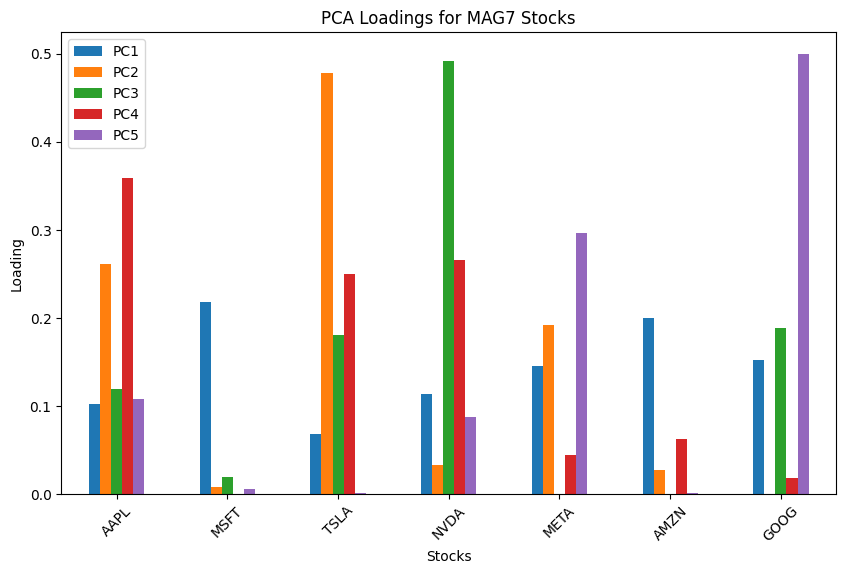

In [104]:
import pandas as pd
from sklearn.decomposition import PCA

# Assume df is your DataFrame with MAG7 stock returns
MAG7_returns = np.log(prices.iloc[-252:]).diff().dropna()[MAG7_TICKERS]  # e.g., Apple, Tesla, etc.

# Standardize the returns
MAG7_returns = (MAG7_returns - MAG7_returns.mean()) / MAG7_returns.std()

# Perform PCA
pca = PCA(n_components=5)  # Using top 5 components
pca.fit(MAG7_returns)

# Get the loadings (weights) of the principal components
loadings = pca.components_

# Create a DataFrame to show the loadings with the stock tickers as the index
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=MAG7_TICKERS)

# Display the loadings
print(loadings_df)

# Optionally, you can also visualize the loadings
import matplotlib.pyplot as plt
(loadings_df**2).plot(kind='bar', figsize=(10, 6))
plt.title('PCA Loadings for MAG7 Stocks')
plt.ylabel('Loading')
plt.xlabel('Stocks')
plt.xticks(rotation=45)
plt.show()

In [107]:
fig = go.Figure()


for pc in loadings_df.T.columns:
    fig.add_trace(
        go.Bar(
            x = loadings_df.T.index,
            y = loadings_df.T[pc],
            name = pc
        )
    )


fig.update_layout(title = 'PC Loadings, Log Returns (2024.1.1 - 2025.1.1)')
fig.update_yaxes(title = 'Loading')
fig.show()

In [106]:
loadings_df['PC1'].div(loadings_df['PC1'].sum())

AAPL    0.123023
MSFT    0.179270
TSLA    0.100567
NVDA    0.129423
META    0.146306
AMZN    0.171617
GOOG    0.149793
Name: PC1, dtype: float64

In [99]:
mag7_weights_normalized_ts.iloc[-1]

Ticker
AAPL    0.214825
MSFT    0.177851
TSLA    0.073571
NVDA    0.186645
META    0.083886
AMZN    0.130921
GOOG    0.132300
Name: 2024-12-31, dtype: float64

PC1    0.849878
PC2    0.004578
PC3    0.093233
PC4    0.127791
PC5    0.033022
Name: Correlation with S&P 500, dtype: float64


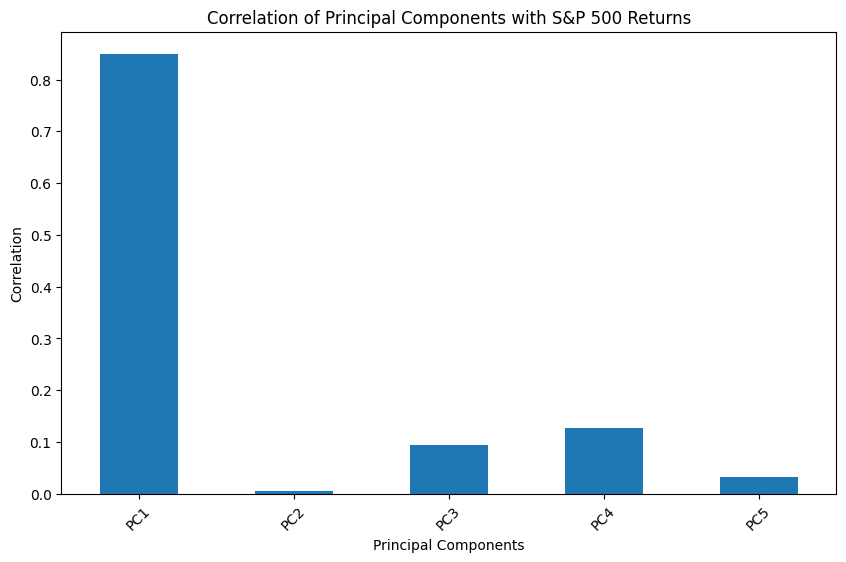

In [92]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'df' is your DataFrame containing the MAG7 returns and 'sp500_returns' is the S&P 500 returns

# Standardize the data (you've already done this when running PCA)
MAG7_returns = (returns[MAG7_TICKERS] - returns[MAG7_TICKERS].mean()) / returns[MAG7_TICKERS].std()

# Perform PCA
pca = PCA(n_components=5)  # Assume you're using the top 5 components
pca_scores = pca.fit_transform(MAG7_returns)

# Get the S&P 500 returns
sp500_returns = returns['SPY']  # Adjust this to match your S&P 500 returns column name

# Calculate the correlation between each principal component and S&P 500 returns
correlations = []
for i in range(pca_scores.shape[1]):  # Loop through all principal components
    corr = np.corrcoef(pca_scores[:, i], sp500_returns)[0, 1]
    correlations.append(corr)

# Convert the correlation results into a pandas Series for easy interpretation
correlation_df = pd.Series(correlations, index=[f'PC{i+1}' for i in range(len(correlations))], name='Correlation with S&P 500')
print(correlation_df)

# Optional: Visualize the correlations
import matplotlib.pyplot as plt
correlation_df.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation of Principal Components with S&P 500 Returns')
plt.ylabel('Correlation')
plt.xlabel('Principal Components')
plt.xticks(rotation=45)
plt.show()


In [96]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = correlation_df.index,
        y = correlation_df
    )
)

fig.update_layout(title = 'PC Correlation vs SP500 returns')
fig.show()

##### **d) Does the 2024 drop in Tesla reveal anything? Is that dispositive?**

No, Telsa contributes the least?